## Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import netCDF4
import xarray as xr
from datetime import datetime
import pandas as pd
import matplotlib.patches as mpatches

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

## Functions

In [2]:
def weighted_temporal_mean(ds):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

## Atmosphere

In [3]:
taux_1989 = xr.open_dataarray('taux_1989_cal_regridded.nc')
tauy_1989 = xr.open_dataarray('tauy_1989_cal_regridded.nc')
taux_2006 = xr.open_dataarray('taux_2006_cal_regridded.nc')
tauy_2006 = xr.open_dataarray('tauy_2006_cal_regridded.nc')
taux_full = xr.open_dataarray('zw_cal_regridded.nc')
tauy_full = xr.open_dataarray('mw_cal_regridded.nc')

In [4]:
rho = 1025
omega = 7.29*10**(-5)
f = 2*omega*np.sin(np.radians(40))
R_d = 50000 # Rossby radius of deformation

W_Ek_1989 = -tauy_1989/(rho*f) # Ekman transport (m^2/s or m^3/s per meter of coast) --> volume transport
Vert_vel_1989 = W_Ek_1989/R_d # Vertical velocity due to Ekman transport (m/s)

W_Ek_2006 = -tauy_2006/(rho*f) # Ekman transport (m^2/s or m^3/s per meter of coast) --> volume transport
Vert_vel_2006 = W_Ek_2006/R_d # Vertical velocity due to Ekman transport (m/s)

W_Ek_base = -tauy_full/(rho*f)
Vert_vel_base = W_Ek_base/R_d

In [6]:
Vert_vel_mean = Vert_vel_1989.mean('time')

In [7]:
coastal_indices = np.zeros(Vert_vel_mean.lat.size)
for i, lat in enumerate(Vert_vel_mean):
    idx = np.argwhere(lat.values==lat[~np.isnan(lat)][-1].values)
    coastal_indices[i] = idx[0,0]

Vert_vel_coastal_1989 = Vert_vel_1989.transpose('lat','lon','time')
for i, lat in enumerate(Vert_vel_coastal_1989):
    Vert_vel_coastal_1989[i] = lat.where(lat.lon == lat.lon[int(coastal_indices[i])].item())
    
Vert_vel_coastal_2006 = Vert_vel_2006.transpose('lat','lon','time')
for i, lat in enumerate(Vert_vel_coastal_2006):
    Vert_vel_coastal_2006[i] = lat.where(lat.lon == lat.lon[int(coastal_indices[i])].item())
    
Vert_vel_coastal_base = Vert_vel_base.transpose('lat','lon','time')
for i, lat in enumerate(Vert_vel_coastal_base):
    Vert_vel_coastal_base[i] = lat.where(lat.lon == lat.lon[int(coastal_indices[i])].item())

In [8]:
# Calculate wind stress curl

x = taux_1989.lon.values
y = taux_1989.lat.values

dx = np.cos(np.radians(-30))*111000
dy = 111000

curl_1989 = tauy_1989.differentiate('lon')/dx - taux_1989.differentiate('lat')/dy
curl_2006 = tauy_2006.differentiate('lon')/dx - taux_2006.differentiate('lat')/dy
curl_base = tauy_full.differentiate('lon')/dx - taux_full.differentiate('lat')/dy

In [9]:
Ek_pump_1989 = 1/(rho*f)*curl_1989 # Ekman pumping velocity (m/s)
Ek_pump_2006 = 1/(rho*f)*curl_2006 # Ekman pumping velocity (m/s)
Ek_pump_base = 1/(rho*f)*curl_base # Ekman pumping velocity (m/s)

In [10]:
X, Y = np.meshgrid(x, y)

In [11]:
Upwelling_1989 = Ek_pump_1989.combine_first(Vert_vel_coastal_1989)
Upwelling_2006 = Ek_pump_2006.combine_first(Vert_vel_coastal_2006)
Upwelling_base = Ek_pump_base.combine_first(Vert_vel_coastal_base)

In [12]:
skip = (slice(None, None, 2), slice(None, None, 2)) # Skip some data points for less arrow density

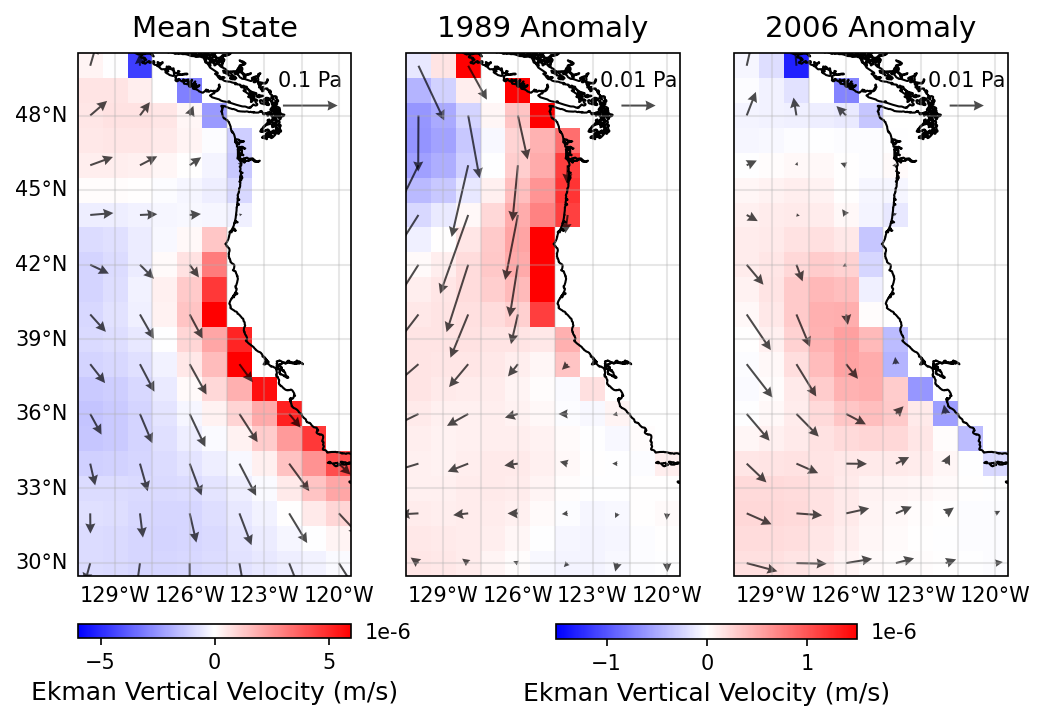

In [13]:
fig, ax = plt.subplots(1, 3, subplot_kw={'projection':ccrs.PlateCarree()}, dpi=150, figsize=(8,7))

for i, axis in enumerate(ax):
    axis.coastlines()
    gl = axis.gridlines(crs=ccrs.PlateCarree(), alpha=.3, linewidth=1)
    gl.bottom_labels = True
    if i==0: gl.left_labels=True
        
cf = ax[0].pcolormesh(x, y, Upwelling_base.mean('time'), cmap='bwr', vmin=-6e-6, vmax=6e-6)
q1 = ax[0].quiver(X[skip], Y[skip], taux_full.mean('time')[skip], tauy_full.mean('time')[skip], 
             scale=.5, headwidth=5, alpha=0.7)
cbar = plt.colorbar(cf, ax=ax[0], orientation='horizontal', pad=0.06)
cbar.ax.xaxis.get_offset_text().set_alpha(0)
cbar.set_label('Ekman Vertical Velocity (m/s)', fontsize=12)
ax[0].quiverkey(q1, 0.85, 0.9, 0.1, '0.1 Pa')

Upwelling_diff = Upwelling_1989.mean('time')-Upwelling_base.mean('time')
taux_diff = taux_1989.mean('time')-taux_full.mean('time')
tauy_diff = tauy_1989.mean('time')-tauy_full.mean('time')

cf = ax[1].pcolormesh(x, y, Upwelling_diff, cmap='bwr', vmin=-1.5e-6, vmax=1.5e-6)
q2 = ax[1].quiver(X[skip], Y[skip], taux_diff[skip], tauy_diff[skip], headwidth=5, scale=0.08, alpha=0.7)
ax[1].quiverkey(q2, 0.85, 0.9, 0.01, '0.01 Pa')

Upwelling_diff = Upwelling_2006.mean('time')-Upwelling_base.mean('time')
taux_diff = taux_2006.mean('time')-taux_full.mean('time')
tauy_diff = tauy_2006.mean('time')-tauy_full.mean('time')

cf = ax[2].pcolormesh(x, y, Upwelling_diff, cmap='bwr', vmin=-1.5e-6, vmax=1.5e-6)
q3 = ax[2].quiver(X[skip], Y[skip], taux_diff[skip], tauy_diff[skip], headwidth=5, scale=0.08, alpha=0.7)
ax[2].quiverkey(q3, 0.85, 0.9, 0.01, '0.01 Pa')

ax[0].set_title('Mean State', pad=8, fontsize=14)
ax[1].set_title('1989 Anomaly', pad=8, fontsize=14)
ax[2].set_title('2006 Anomaly', pad=8, fontsize=14)

cbar = fig.colorbar(cf, ax=ax[1:3], orientation='horizontal', pad=0.06, shrink=0.5)
cbar.ax.xaxis.get_offset_text().set_alpha(0)
cbar.set_label('Ekman Vertical Velocity (m/s)', fontsize=12)

ax[0].text(1.05,-0.12, '1e-6', transform=ax[0].transAxes)
ax[1].text(1.7,-0.12, '1e-6', transform=ax[1].transAxes)

fig.patch.set_fill(False)

plt.show()

## Oxygen

In [14]:
california_O2_1989 = xr.open_dataarray('O2_california_1989_regridded.nc')
california_O2_2006 = xr.open_dataarray('O2_california_2006_regridded.nc')

In [15]:
california_O2_1989 = weighted_temporal_mean(california_O2_1989)
california_O2_2006 = weighted_temporal_mean(california_O2_2006)

/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(
/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(
/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(
/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(


In [16]:
california_O2min_1989 = xr.open_dataarray('O2min1989_california_regridded.nc')
california_O2min_2006 = xr.open_dataarray('O2min2006_california_regridded.nc')

california_O2min_1989 = weighted_temporal_mean(california_O2min_1989)
california_O2min_2006 = weighted_temporal_mean(california_O2min_2006)

/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(
/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(
/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(
/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(


In [17]:
def find_volume(region, threshold):
    vol = xr.where(region<=threshold, 1, 0)
    vol = vol.transpose('z_t','time','lat','lon')

    width = 111000*np.cos(np.deg2rad(30))
    length = 111000
    for i, depth in enumerate(vol):
        if i == 0:
            height = (vol.z_t[0]*2).values
        elif i == len(vol)-1:
            height = (vol.z_t[i]-vol.z_t[i-1]).values
        else:
            height = ((vol.z_t[i+1]-vol.z_t[i-1])/2).values
        vol[i] = width*length*height*depth
    return vol.sum(dim=('lat','lon','z_t'))

california_volumes_1989_20 = find_volume(california_O2_1989, 20)
california_volumes_1989_60 = find_volume(california_O2_1989, 60)
california_volumes_2006_20 = find_volume(california_O2_2006, 20)
california_volumes_2006_60 = find_volume(california_O2_2006, 60)


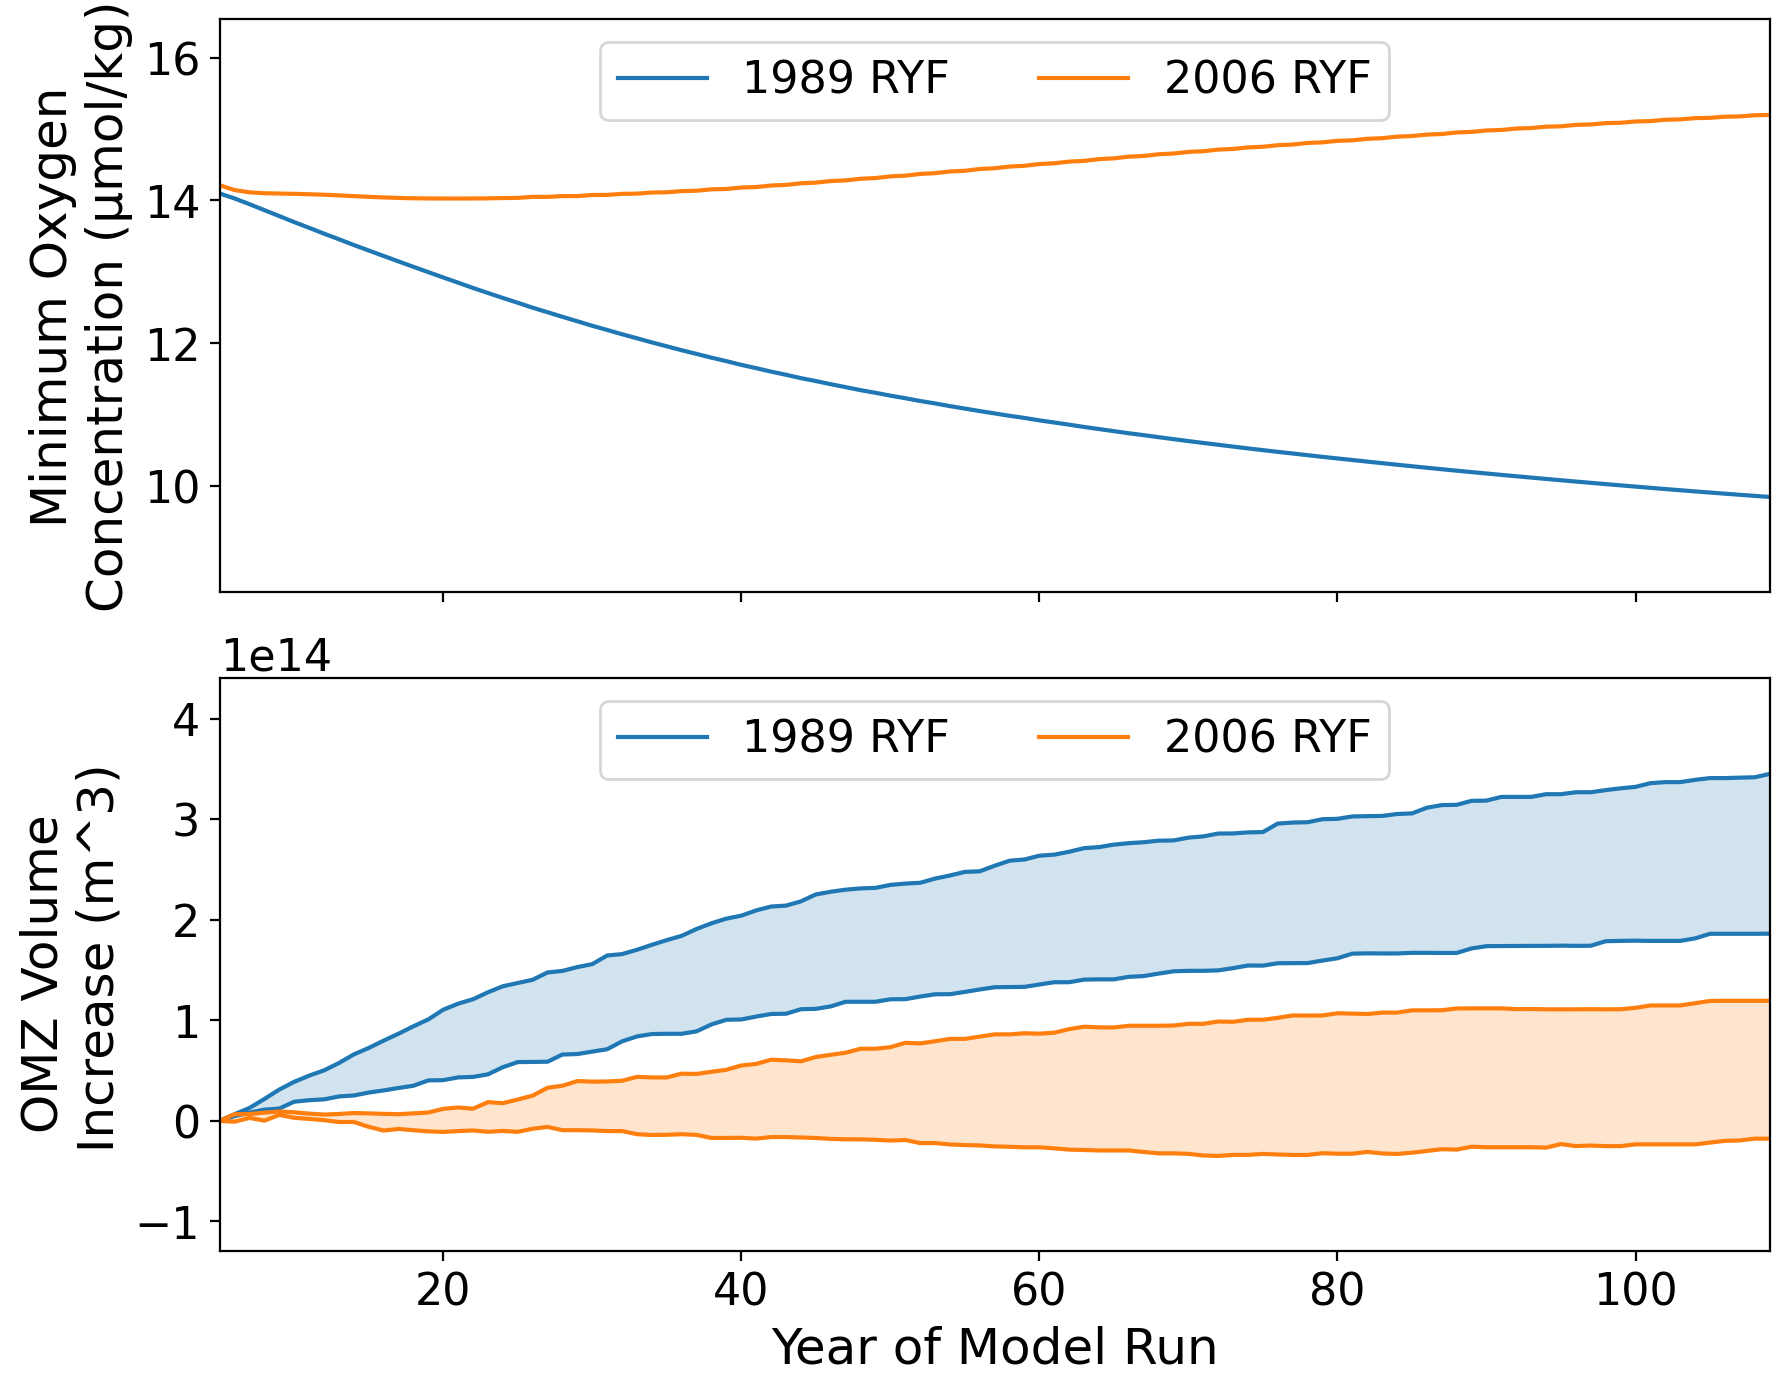

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True, dpi=200)

y1 = california_O2min_1989.mean(dim=('lat', 'lon'))[5:]
y2 = california_O2min_2006.mean(dim=('lat', 'lon'))[5:]
x = y1['time.year']-2011

ax[0].plot(x, y1, label='1989 RYF')
ax[0].plot(x, y2, label='2006 RYF')
ax[0].margins(0, 0.25)
ax[0].set_ylabel('Minimum Oxygen\nConcentration (µmol/kg)', fontsize=18)
ax[0].legend(fontsize=16, ncol=2, loc='upper center')

x = california_O2_1989['time.year'][5:]-2011
y1 = california_volumes_1989_20[5:] - california_volumes_1989_20[5:][0]
y2 = california_volumes_1989_60[5:] - california_volumes_1989_60[5:][0]
y3 = california_volumes_2006_20[5:] - california_volumes_2006_20[5:][0]
y4 = california_volumes_2006_60[5:] - california_volumes_2006_60[5:][0]

ax[1].plot(x, y1, label='1989 RYF')
ax[1].plot(x, y2, color='tab:blue')
ax[1].plot(x, y3, label='2006 RYF')
ax[1].plot(x, y4, color='tab:orange')
ax[1].fill_between(x, y1, y2, alpha=0.2)
ax[1].fill_between(x, y3, y4, alpha=0.2)
ax[1].yaxis.get_offset_text().set_fontsize(16)
ax[1].margins(0, 0.25)
ax[1].set_xlabel('Year of Model Run', fontsize=18)
ax[1].set_ylabel('OMZ Volume \n Increase (m^3)', fontsize=18)
ax[1].legend(fontsize=16, ncol=2, loc='upper center')

for axis in ax:
    axis.tick_params('both', labelsize=16)
    
plt.subplots_adjust(hspace=0.15)

plt.show()